# Imports

In [120]:
%load_ext autoreload
%autoreload
from kofscraper import keywords_utils, config, load_utils
import polars as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [159]:
data = load_utils.load_multiple_files(config.PATENTS_DATA + "CH*.xlsx", "excel")[:, 1:4].filter(pl.col("Publication number").is_not_null())

Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string


In [5]:
data = data.with_columns(
    pl.col("Title").str.replace_all(r"[^\p{Ascii}]", ""),
    pl.col("Abstract").str.replace_all(r"[^\p{Ascii}]", "")
)

In [ ]:
keywords_df = load_utils.load_keywords(config.KEYWORDS_FILE)
#keywords = keywords_df.select(pl.col("prompt_output").str.to_lowercase().str.join(", ")).item()
#kws = [k.strip() for k in keywords.split(", ") if len(k.strip()) > 3]

# Match keywords on the run and on the patents
This code takes long to run, if possible read the output from the files

## Generate files

In [ ]:
keywords_utils.match_keywords(kws, data.lazy(), "Abstract", "Publication number", 10000, "kw_matches")

Building automaton with 55471 keywords
Automaton built
Wrote results to 'data/processed/kw_matches.parquet'
Cleaning up files
Done.


In [ ]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url", "text")
keywords_utils.match_keywords(kws, lf, "text", "url", 50000, "run_kw_matches")

File ARGUS_chunk_p183.parquet is corrupted
Building automaton with 55471 keywords
Automaton built
Percent completed: 4.16%, Time remaining: 0:20:46.546795
Percent completed: 8.32%, Time remaining: 0:21:47.190435
Percent completed: 12.48%, Time remaining: 0:21:54.555746
Percent completed: 16.64%, Time remaining: 0:22:09.492717
Percent completed: 20.79%, Time remaining: 0:20:53.028674
Percent completed: 24.95%, Time remaining: 0:19:34.662762
Percent completed: 29.11%, Time remaining: 0:18:11.557299
Percent completed: 33.27%, Time remaining: 0:16:58.924644
Percent completed: 37.43%, Time remaining: 0:15:38.391050
Percent completed: 41.59%, Time remaining: 0:14:25.889643
Percent completed: 45.75%, Time remaining: 0:13:13.525426
Percent completed: 49.91%, Time remaining: 0:12:14.869863
Percent completed: 54.07%, Time remaining: 0:11:14.552012
Percent completed: 58.23%, Time remaining: 0:10:30.200352
Percent completed: 62.38%, Time remaining: 0:09:32.086741
Percent completed: 66.54%, Time re

OSError: [Errno 39] Directory not empty: 'output'

## Read files and prepare data
If they are already available don't run the above code

In [3]:
keywords_df = load_utils.load_keywords(config.KEYWORDS_FILE)

run_results = load_utils.load_keyword_matches("run_kw_matches.parquet").rename({"ID": "url"})
patent_results = load_utils.load_keyword_matches("kw_matches.parquet").rename({"ID": "Publication number"})

lookup = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").rename({"prompt_output": "keyword"})


### Get the company that submitted a patent

In [4]:
patent_company_lookup = load_utils.load_multiple_files(pattern = config.PATENTS_DATA + "Appl*.csv", filetype="csv")[:, 1:3].rename({"Applicant(s) BvD ID Number(s)": "ID"})
patent_company_lookup = patent_company_lookup.with_columns(pl.col("ID").str.split("; ")).explode("ID")

patent_results = patent_results.join(patent_company_lookup, on = "Publication number", how = "inner")

### Assign BVD to url

In [5]:
import gc

lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url")
run_results = run_results.join(lf.collect(engine = "streaming"), on = "url")

File ARGUS_chunk_p183.parquet is corrupted


### Get categories

In [6]:
patent_results = patent_results.join(lookup, on = "keyword")
run_results = run_results.join(lookup, on = "keyword")

## Compare 

In [151]:
threshold = 1

compare_run = keywords_utils.get_companies_with_n_unique_kws(run_results, threshold)
compare_patent = keywords_utils.get_companies_with_n_unique_kws(patent_results, threshold)
compare = compare_run.join(compare_patent, on = "ID", how = "inner", suffix = "_patent").rename({'category': "category_run"})

del compare_run, compare_patent
gc.collect();

In [152]:
comparison_df = keywords_utils.add_jaccard(compare, "category_run", "category_patent")

Text(0.5, 0, 'Jaccard similarity')

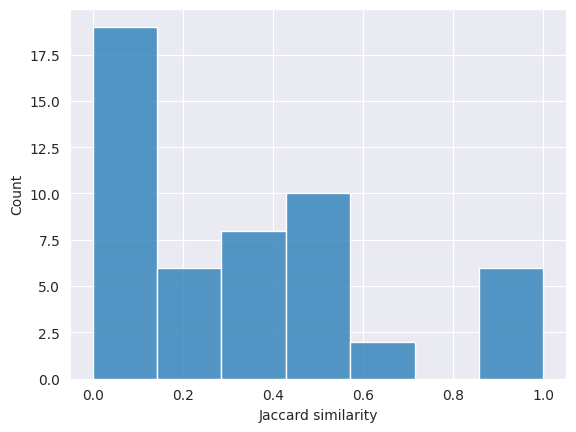

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

sns.histplot(comparison_df["jaccard_similarity"])
plt.xlabel("Jaccard similarity")

In [147]:
comparison_df = comparison_df.with_columns(
    inters = pl.col("category_patent").list.set_intersection("category_run").list.len()
).with_columns(
    p_run_given_patent = pl.col("inters") / pl.col("category_patent").list.len(),
    p_patent_given_run = pl.col("inters") / pl.col("category_run").list.len(),
).select(pl.exclude("inters"))

<Axes: >

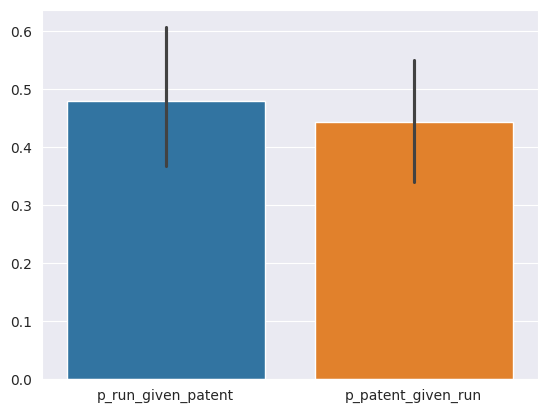

In [148]:
sns.barplot(
    [comparison_df["p_run_given_patent"], comparison_df["p_patent_given_run"]]
)

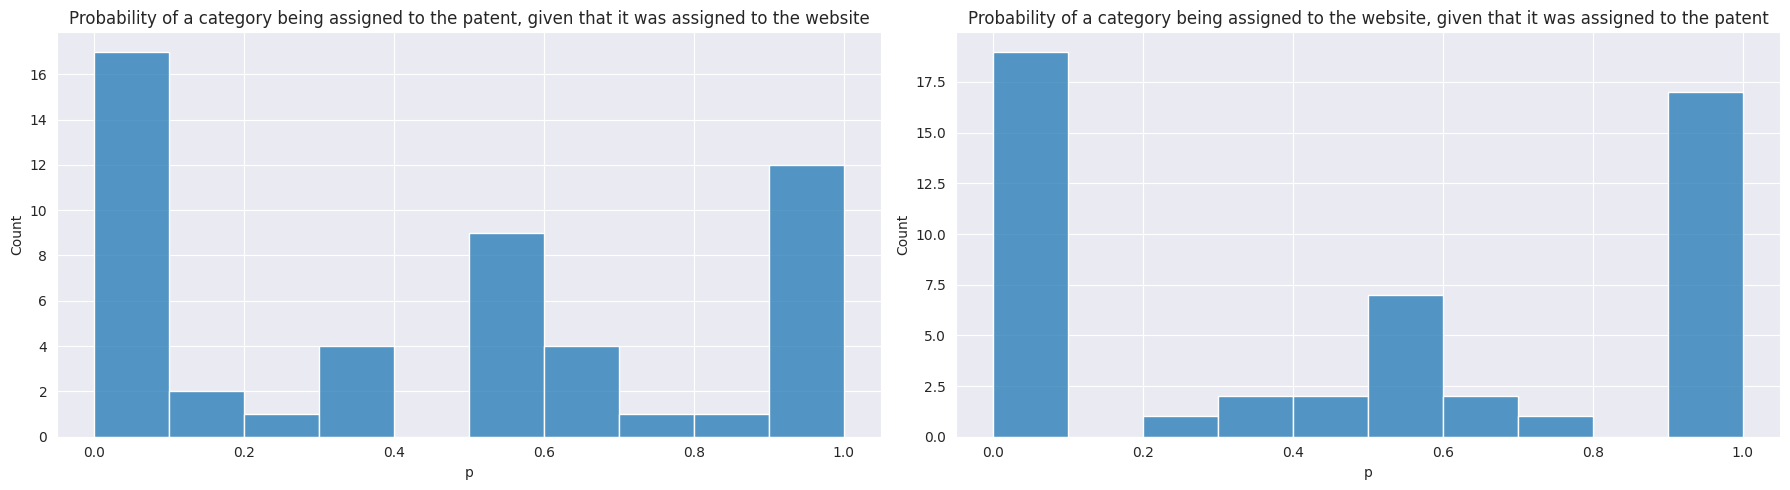

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot on the first subplot
sns.histplot(comparison_df["p_patent_given_run"], bins = 10, ax=axes[0])
axes[0].set_title('Probability of a category being assigned to the patent, given that it was assigned to the website')
axes[0].set_xlabel("p")

# Plot on the second subplot
sns.histplot(comparison_df["p_run_given_patent"], bins = 10,ax=axes[1])
axes[1].set_title('Probability of a category being assigned to the website, given that it was assigned to the patent')
axes[1].set_xlabel("p")

# Adjust the spacing between plots
plt.tight_layout()

# Display the plot
plt.show()


In [153]:
avg_n_categories_website = comparison_df.with_columns(
    pl.col("category_run").list.len()
).select(pl.col('category_run').mean()).item()
avg_n_categories_patents = comparison_df.with_columns(
    pl.col("category_patent").list.len()
).select(pl.col('category_patent').mean()).item()

print("Average number of categories on websites: ", avg_n_categories_website)
print("Average number of categories on patents: ", avg_n_categories_patents)

Average number of categories on websites:  5.838095238095238
Average number of categories on patents:  3.487619047619048


We find less categories for patents, not surprising as it's a "contolled" environmet, there is less noise. 

***Interestingly,*** this does not hold for higher numbers of unique keywords

In [137]:
category_list = keywords_df["category"].to_list()
p_patent_given_web = []
p_web_given_patent = []
for cat in category_list:
    p_patent_given_web.append(keywords_utils.find_conditional_probability(comparison_df, "category_run", cat))
    p_web_given_patent.append(keywords_utils.find_conditional_probability(comparison_df, "category_patent", cat))

conditional_prob_df = pl.DataFrame({"category": category_list, "p_patent_given_web": p_patent_given_web, "p_web_given_patent": p_web_given_patent}).sort("p_patent_given_web", descending=True)

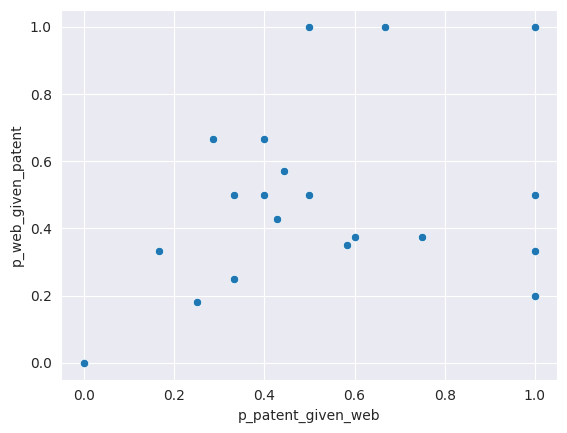

In [157]:
p = sns.scatterplot(
    x = conditional_prob_df["p_patent_given_web"],
    y = conditional_prob_df["p_web_given_patent"]   
)

# idx = 0
# for point in conditional_prob_df.iter_rows():
#     p.text(point[1], point[2], idx)
#     idx += 1